In [1]:
# Test of module qilum.stats


In [2]:
import qilum.stats as qs

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import numba as nb
import scipy.stats 
from contextlib import suppress


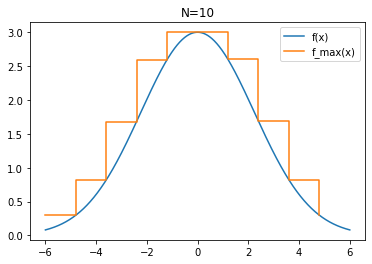

In [4]:
def test_f_max():
    """test f_max function: for a serie of values array ys and integer N,
    separate yz in N intervals and return the max of ys for each interval""" 
    # input
    xs = np.linspace(-6,6, 1001)
    ys = 3.*np.exp(-np.square(xs)/10.)

    # calcul
    xs_inter, ys_inter = qs.f_max(xs, ys, 10)    

    # plot
    plt.plot(xs, ys, label='f(x)')
    plt.step(xs_inter[:-1], ys_inter, where='post',label='f_max(x)')
    plt.title('N=10')
    plt.legend()
#         plt.savefig(r'pkg\docs\source\_static\f_max.jpg', bbox_inches='tight')

if __name__ == "__main__":
    test_f_max()

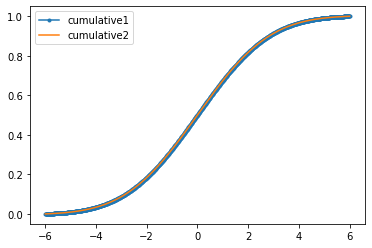

In [6]:
def test_f_cumulative():
    """test f_cumulative function: for a serie of values array xs and ys, calculate dxs*ys.""" 
    # input
    xs = np.linspace(-6,6, 1001)
    ys = 3.*np.exp(-np.square(xs)/10.)

    # calcul
    # same size for xs and ys
    cumulative1 = qs.f_cumulative(xs, ys, normalized=True)            

    # xs are intervals where ys are constant: xs.size = ys.size+1 
    ys = 0.5*(np.roll(ys,-1)+ys)[:-1]
    cumulative2 = qs.f_cumulative(xs, ys, normalized=True)    

    # plot
    plt.plot(xs[1:], cumulative1, label='cumulative1',marker='.')
    plt.plot(xs[1:], cumulative2, label='cumulative2')
    plt.legend()
#     plt.savefig(r'..\qilum\docs\source\_static\f_cumulative.jpg', bbox_inches='tight')
    
    
if __name__ == "__main__":
    test_f_cumulative()

P0= [0.37037037 0.74074074 0.         0.88888889 0.40740741]
a= [4 4 2 2 3]
P0*mean= [1.  2.  0.  2.4 1.1]


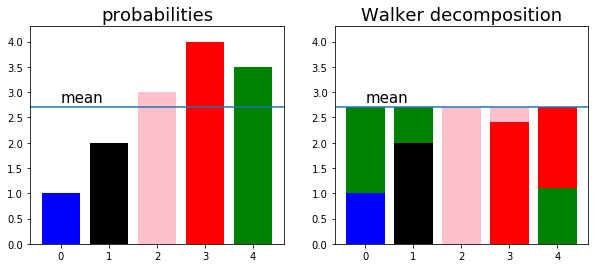

In [8]:
def test_walker_decomposition():
    """test f_walker : Walker decomposition: 
    given N probabilities , return a series of N boxes of value mean(probabilities) 
    with 2 indices in each"""

    # calcul
    probabilities = np.array([1,2,3,4,3.5], dtype=np.float64)
    P0, a = qs.f_walker(probabilities)
    print("P0=",P0)
    print("a=",a)

    # figure
    mean = probabilities.mean()
    colors = np.array(['blue','black','pink','red','green'])
    P1 = 1-P0        
    P0 = P0*mean
    P1 = P1*mean
    ind = np.arange(P0.size)        
    print("P0*mean=",P0)

    # plot
    plt.figure(figsize=(10,4))

    plt.subplot(1,2,1)
    plt.ylim(0,4.3)
    plt.bar(ind, probabilities, color=colors)
    plt.axhline(y=mean)
    plt.text(0, mean+0.1, 'mean', fontsize=15)
    plt.title('probabilities', fontsize=18)

    plt.subplot(1,2,2)
    plt.ylim(0,4.3)
    plt.bar(ind, P0, color=colors)
    plt.bar(ind, P1, bottom=P0, color=colors[a])
    plt.axhline(y=mean)
    plt.text(0, mean+0.1, 'mean', fontsize=15)
    plt.title('Walker decomposition', fontsize=18)
#         plt.savefig(r'pkg\docs\source\_static\f_walker.jpg', bbox_inches='tight')

if __name__ == "__main__":
    test_walker_decomposition()

In [ ]:
def test_walker_speed_comparison():
    """Compare speed of walker distribution to several other distributions
    The walker distribution has no dependency on the number of input 
    and is the fastest among the distributions"""

    np.random.seed(123456)
    size_input = np.array([2,3,4,5,7,10,15,20,30,40,50,70,100,150,200,250])

    time_walker = np.zeros(size_input.size, dtype=float)
    time_distri = np.zeros(size_input.size, dtype=float)
    time_histo  = np.zeros(size_input.size, dtype=float)
    time_choice = np.zeros(size_input.size, dtype=float)

    Nran = 100000
    print('number of random numbers = ',Nran/1000000,'.10^6')

    for i in range(size_input.size):
        values = np.arange(0,size_input[i])
        probabilities = np.random.uniform(0,1,values.size)
        probabilities /= probabilities.sum() 

        distrib   = scipy.stats.rv_discrete(values=(values, probabilities))
        disthisto = scipy.stats.rv_histogram((probabilities, np.arange(0,probabilities.size+1)))
        walker    = qs.Dist_walker(probabilities, values)

        timeit_walker    = %timeit -o -q -r 10 -n 2 walker.rvs(size=Nran)
        timeit_distrib   = %timeit -o -q -r 10 -n 1 distrib.rvs(size=Nran)
        timeit_disthisto = %timeit -o -q -r 10 -n 3 values[disthisto.rvs(size=Nran).astype(int)]
        timeit_choice    = %timeit -o -q -r 10 -n 3 values[np.random.choice(values, Nran, p=probabilities)]

        time_walker[i] = timeit_walker.average
        time_distri[i] = timeit_distrib.average
        time_histo[i]  = timeit_disthisto.average
        time_choice[i] = timeit_choice.average
        print(size_input[i], end=', ')
    print()

    # plot 
    coeff = time_walker[3]
    plt.axhline(y=1, color='black')
    plt.plot(size_input,time_distri/coeff, label='scipy.discrtete')
    plt.plot(size_input,time_histo/coeff, label='scipy.histogram')
    plt.plot(size_input,time_choice/coeff, label='np.choice')
    plt.plot(size_input,time_walker/coeff, label='Dist_walker')
    plt.xlabel('size of inputs')
    plt.ylabel('time (s)')
    plt.title('speed comparison for 10^6 random nb')
    plt.tick_params(labelright=True)
    plt.legend()        
        
if __name__ == "__main__":
    test_walker_speed_comparison() 

In [ ]:

def test_Dist_walker():

    print('test Dist_walker distribution --------------------------------------------------')

    # input and calculation
    values = np.array([0, 10, 2])
    probabilities = np.array([0.2, 0.5, 0.3])
    scipy_discrete = scipy.stats.rv_discrete(values=(values, probabilities))
    walker = qs.Dist_walker(probabilities, values)

    print('probabilities = ',walker.probabilities)
    print('values        = ',walker.values)

    # figure
    fig = plt.figure(figsize=(15,3))

    # plot histogram of random value and compare it to the probability mass function
    plt.subplot(1,3,1)
    rans = walker.rvs(size=100000)
    hist, bins = np.histogram(rans, bins = np.linspace(-0.5,10.5, 12))
    bins = 0.5*(bins[:-1] + bins[1:])
    plt.bar(bins, hist/(hist.sum()*(bins[1]-bins[0])), label='histo')
    plt.scatter(bins, walker.pmf(bins.astype(int)), c='red', label='exact')
    plt.legend()
    plt.title('histogram')

    # plot walker.function
    xs = np.linspace(-4,12,1601)
    ys = walker.f(xs)
    plt.plot(xs,ys, label='f(x)', color='pink')
    plt.legend()
    plt.title('f()')

    # plot walker cumulative and the probability density function 
    plt.subplot(1,3,2)
    xs = np.linspace(-20,20,4001)
    ys = walker.cdf(xs)
    plt.plot(xs,ys, linewidth=8, color='pink',  label='cdf_walker')
    ys = scipy_discrete.cdf(xs)
    plt.plot(xs,ys, linewidth=3, color='red',  label='cdf_stats.rv_discrete')
    ys = np.linspace(0,1,1001)
    xs_ppf = walker.ppf(ys)
    plt.plot(xs_ppf,ys, linewidth=1, color='blue',  label='ppf_walker')
    plt.legend()
    plt.title('cumulative')


    plt.subplot(1,3,3)
    test_walker_speed_comparison()
#         plt.savefig(r'pkg\docs\source\_static\Dist_walker.jpg', bbox_inches='tight')
    plt.show()

if __name__ == "__main__":
    test_Dist_walker()        



    

In [9]:
def f_hist(*args, bins, density=True):    
    """helper function"""
    hist, bins = np.histogram(args, bins=bins, density=density)
    bins = (bins[1:]+bins[:-1])/2.
    return hist, bins

def f_test_histogram_cumulative(dist, xs, NMC, underlying=False, filename = None): 
    """test for continuous distributions"""
    fig = plt.figure(figsize=(15,3))
    
    # ran x
    plt.subplot(1,2,1)
    rans = dist.rvs(NMC)
    ys = dist.f(xs)
    hist, bins = f_hist(rans, bins=200)
    try:
        factor = dist.F_tot()
    except:
        index = np.argmax(hist)
        x_max = bins[index]        
        factor = dist.f(x_max)/hist[index]
    plt.plot(bins, hist*factor, color= 'pink', linewidth=8, label='histo')
    plt.plot(xs,ys, color= 'green', linewidth=3, label='f(x)')
    if underlying:
        plt.plot(xs,dist.f_underlying(xs), color= 'red', linewidth=3, label='f_' + dist.dist_ran.name() + '(x)')
        
    
    with suppress(Exception):         
        ys_pdf = dist.pdf(xs)*dist.F_tot()
        plt.plot(xs,ys_pdf, color= 'black', linewidth=1, label='pdf(x)*F_tot)')
    plt.legend(loc='upper left')
    plt.title('ran ' + dist.name())
    
    # Cumulative
    plt.subplot(1,2,2)
    # calculate approximate 
    cum = qs.f_cumulative(xs,ys)
    cum /= cum[-1]
    plt.plot(xs[1:],cum, color= 'green', linewidth=8, label='cum approximate')
    with suppress(Exception):         
        ys = dist.cdf(xs)
        plt.plot(xs,ys, color= 'blue', linewidth=3, label='y = cdf(x)')
    with suppress(Exception):         
        xs_ppf = dist.ppf(ys)
        plt.plot(xs_ppf,ys, color= 'pink', linewidth=2, label='x= ppf(y)')
    plt.legend(loc='upper left')
    plt.title('cumulative ' + dist.name())
    
    if filename is not None:
        filename = '..\\qilum\\docs\\source\\_static\\' + filename
        print('saving : ', filename)
        plt.savefig(filename, bbox_inches='tight')
    plt.show()
    


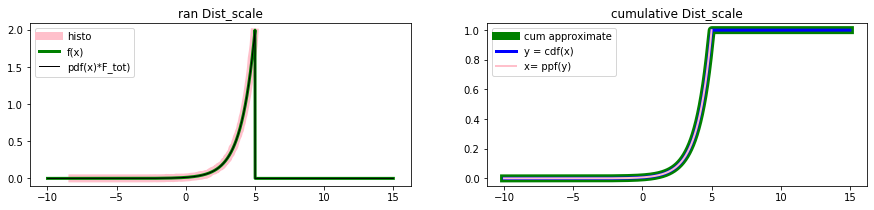

In [10]:
def test_Dist_scale():
    """test for scaling of distributions """
    # scipy dist
    dist_exp = scipy.stats.expon()    
    # scale scipy dist with negative scale_x and multiplicative factor scale_y
    dist = qs.Dist_scale(dist_exp, loc_x=5, scale_x=-1, scale_y=2)
    # plot histogram and cumulative
    xs = np.linspace(-10, 15, 10000)
    f_test_histogram_cumulative(dist, xs, 100000)

if __name__ == "__main__":
    test_Dist_scale()

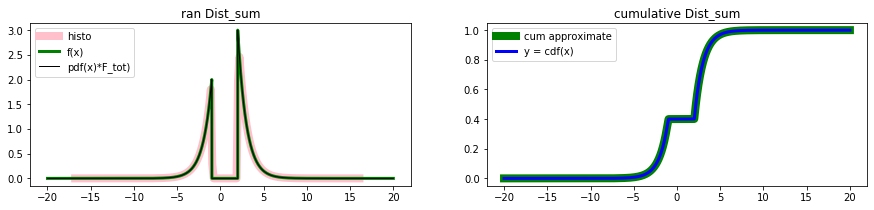

In [11]:
def test_Dist_sum():
    """test for Sum of distributions """

    # exponential distributions left and right types
    exp_left  = qs.Dist_scale(scipy.stats.expon(),loc_x=-1, scale_x=-1, scale_y=2, name='Exp+')
    exp_right = qs.Dist_scale(scipy.stats.expon(),loc_x= 2, scale_x= 1, scale_y=3, name='Exp-')

    # sum of the distributions
    dist_sum = qs.Dist_sum([exp_left, exp_right]); 

    # plot histogram and cumulative
    xs = np.linspace(-20,20, 100001)
    f_test_histogram_cumulative(dist_sum, xs, 10000000)

if __name__ == "__main__":
    test_Dist_sum()

saving :  ..\qilum\docs\source\_static\Dist_sum_2.jpg


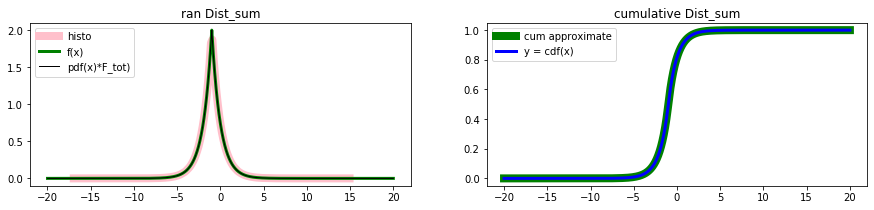

In [20]:
def test_Dist_sum2():
    """test for Sum of distributions """

    # Sum of distributions
    # exponential distributions left and right types
    exp_left  = qs.Dist_scale(scipy.stats.expon(),loc_x=-1.000001, scale_x=-1, scale_y=2, name='Exp+')
    exp_right = qs.Dist_scale(scipy.stats.expon(),loc_x= -1, scale_x= 1, scale_y=2, name='Exp-')
    # sum of the distributions
    dist_sum = qs.Dist_sum([exp_left, exp_right]); 
    # random numbers
    rans = dist_sum.rvs(100)
    
    # plot histogram and cumulative
    xs = np.linspace(-20,20, 100001)
    f_test_histogram_cumulative(dist_sum, xs, 10000000, filename = 'Dist_sum_2.jpg')

if __name__ == "__main__":
    test_Dist_sum2()

saving :  ..\qilum\docs\source\_static\Dist_reject2.jpg


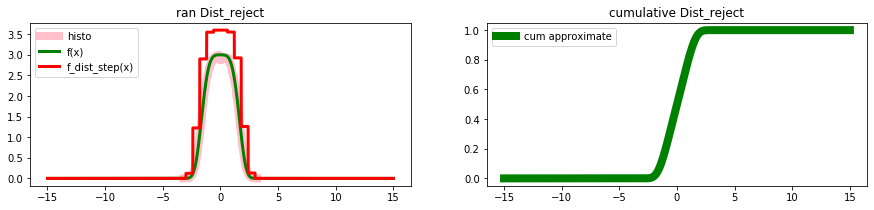

In [18]:
def test_Dist_reject2():
    """
    """    
    # generate a random generator for f_f(x)     
    def f_f(xs): return np.where((xs<-5) | (xs>5), 0, 3.*np.exp(-np.power(xs,4)/10.))
    
    # find a step function above f_f(x): *1.2 to be dure that step function >= f_f()
    xs = np.linspace(-6,6, 1001)
    ys = f_f(xs)
    xs_step, ys_step = qs.f_max(xs, ys, 20)    
    ys_step *= 1.2 # just to be sure that our step function >= f_f() 

    # create a distribution for this step function:
    hist_dist = scipy.stats.rv_histogram((ys_step, xs_step))
    # scale this diribution
    cumulative = qs.f_cumulative(xs_step, ys_step)[-1]
    dist_step = qs.Dist_scale(hist_dist, scale_y = cumulative, name='dist_step')

    # create dist_reject 
    dist_reject = qs.Dist_reject(dist_step, f_f)
    
    # random numbers
    rans = dist_reject.rvs(100)

    # plot histogram and cumulative for rejection method distribution
    xs = np.linspace(-15,15, 100001)
#     f_test_histogram_cumulative(dist_reject, xs, 1000000, True, 'Dist_reject2.jpg')
    f_test_histogram_cumulative(dist_reject, xs, 1000000, True, None)

if __name__ == "__main__":
    test_Dist_reject2()

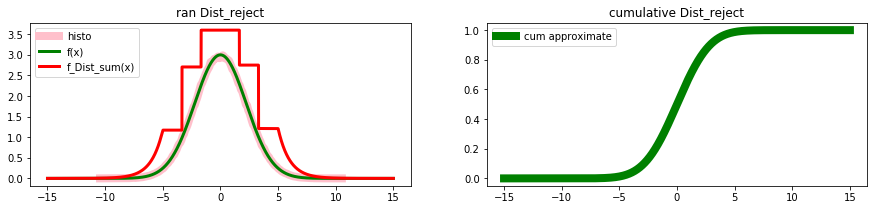

Normal distribution test =  True  with  p = 0.899053


In [16]:
def test_Dist_reject():
    """
    1. create a function f_sum(x) above the function f_f(x). The f_sum is defined on three intervals.
    2. create a sum of the known distributions for each part of f_sum function
    3. create the Dist_rejection distribution using this sum and the original f_f(x) function        
    """
    def f_f(xs):
        return 3.*np.exp(-np.square(xs)/10.)

    # 1.create a function f_sum(x) above the function f_f(x).
    #   f_sum(x) = y0*exp(+a*x)  if x_min < x 
    #   f_sum(x) = step function if x_min < x <= x_max 
    #   f_sum(x) = y0*exp(-a*x)  if x_max < x               
    xs = np.linspace(-5,5, 1001)
    ys = f_f(xs)    
    xs_inter, ys_inter = qs.f_max(xs, ys, 6)    
    ys_inter *= 1.2 # just to be sure that our step function >= f_f() 
    # histogram distribution with the step function
    hist_dist = scipy.stats.rv_histogram((ys_inter, xs_inter))
    # scale this diribution
    cumulative = ((np.roll(xs_inter,-1)-xs_inter)[:-1]*ys_inter).sum()
    step = qs.Dist_scale(hist_dist, scale_y = cumulative)

    # exponential distribution at the left and right of the step distribution
    exp_left  = qs.Dist_scale(scipy.stats.expon(),loc_x=xs_inter[-1], scale_x=1, scale_y=ys_inter[-1], name='Exp+')
    exp_right = qs.Dist_scale(scipy.stats.expon(),loc_x=xs_inter[0]-1e-10, scale_x=-1,scale_y=ys_inter[0], name='Exp-')

    # 2. create a sum of the known distributions for each part of f2 function
    dist_sum    = qs.Dist_sum([exp_left, step, exp_right]) 
    # 3. create the Dist_rejection distribution using this sum and the original f_f(x) function        
    dist_reject = qs.Dist_reject(dist_sum, f_f)

    # plot histogram and cumulative for rejection method distribution
    xs = np.linspace(-15,15, 100001)
    f_test_histogram_cumulative(dist_reject, xs, 1000000, True)

    # test result with the normal distribution hypothesis
    k2, p = scipy.stats.normaltest(dist_reject.rvs(100000))
    print("Normal distribution test = ",p > 1e-3, " with ", "p = {:g}".format(p))        
        
if __name__ == "__main__":
    test_Dist_reject()

In [ ]:
def test_Dist_cubic_spline():
    """test for Cubic spline approximation """
    
    # test function: gaussian
    def f_f(xs):
        return 3.*np.exp(-np.square(xs)/10.)

    # initialize class
    x = np.linspace(-12, 12, 51)
    y = f_f(x)  
    dist_cs = qs.Dist_cubicSpline(x, y, N_cs=1000)

    # plot histogram and cumulative
    xs = np.linspace(-20, 20, 10000)
    f_test_histogram_cumulative(dist_cs, xs, 100000)

if __name__ == "__main__":
    test_Dist_cubic_spline()        